In [134]:
import random
import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

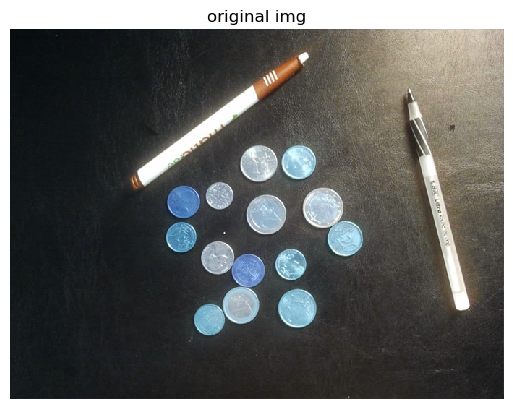

In [135]:
img = cv.imread('money2.jpg')
# img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('original img')
plt.axis('off')  # Turn off axis
plt.show()



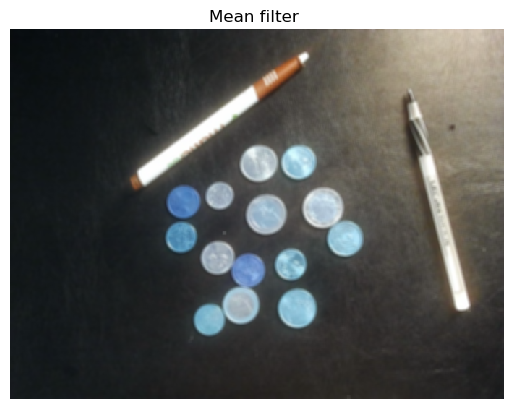

In [136]:
#create the kernel mean
kernelMean =  np.ones((5,5),np.float32)/ 25 # 

# apply it to the image now 
imgMean = cv.filter2D(img,-1,kernelMean)# 

#show it after 
plt.imshow(imgMean)
plt.title('Mean filter ')
plt.axis('off')  # Turn off axis
plt.show()

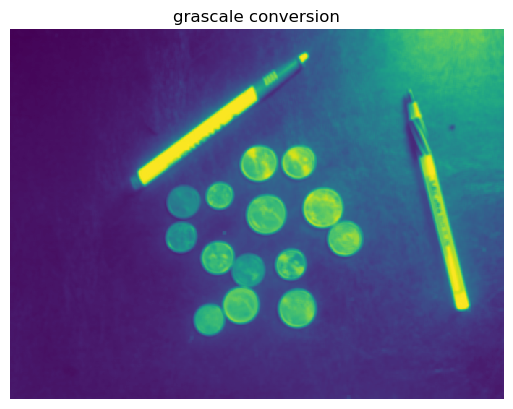

In [137]:
img_gray = cv.cvtColor(imgMean, cv.COLOR_RGB2GRAY)
plt.imshow(img_gray)
plt.title('grascale conversion')
plt.axis('off')  # Turn off axis
plt.show()

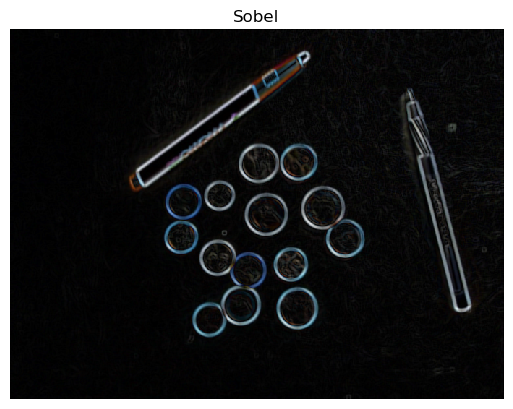

In [138]:
# computes the intensity gradient of the image using a Sobel kernel and plot it on mathplot to see intensity
# imgMean to be able to use the sobel filter 

sobel_x = cv.Sobel(imgMean, cv.CV_64F, 1, 0, ksize=3)
sobel_y = cv.Sobel(imgMean, cv.CV_64F, 0, 1, ksize=3)

gX = cv.convertScaleAbs(sobel_x )
gY = cv.convertScaleAbs(sobel_y)
# combine the gradient representations into a single image
combined = cv.addWeighted(gX, 0.5, gY, 0.5, 0)

plt.imshow(combined)
plt.title('Sobel')
plt.axis('off')  # Turn off axis
plt.show()


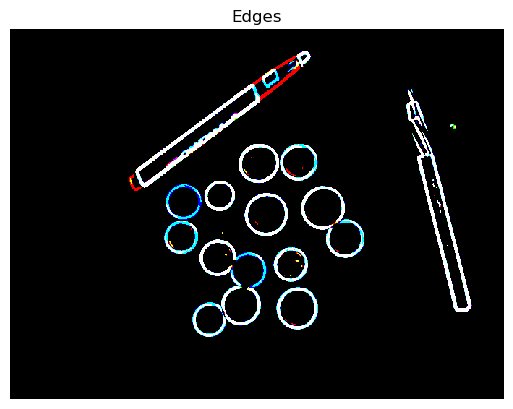

Total edge points: 46010


In [139]:
#remove all pixels that are not an edge using a local maximum and Hysteresis thresholding (i.e.the use of two threshold values to take a decision)
#change it an try doing opening and closing or as using here the gradient magnitude
# Compute the magnitude of the gradient
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
orientation = np.arctan2(gY, gX) * (180 / np.pi) % 180


threshold = 100
edges = np.uint8(gradient_magnitude > threshold) * 255


# Show the edges
plt.imshow(edges)
plt.title('Edges')
plt.axis('off')
plt.show()

edges_points = np.column_stack(np.where(edges > 0))
print("Total edge points:", len(edges_points))


In [142]:





iterations = 1000
edgePoints = edges_points 


radiusThreshold = 2

onCircle = []
notOnCircle = []
bestCircles = []

for i in range(iterations):
    A = edgePoints[random.randint(0, len(edgePoints))]
    B = edgePoints[random.randint(0, len(edgePoints))]
    C = edgePoints[random.randint(0, len(edgePoints))]
    
    midpt_AB = [(A[0] + B[0]) / 2, (A[1] + B[1]) / 2]
    midpt_BC = [(A[0] + B[0]) / 2, (A[1] + B[1]) / 2]
    
    slope_AB = (B[1] - A[1]) / (B[0] - A[0] + 1e-10)
    intercept_AB = A[1] - slope_AB * A[0]
    slope_BC = (C[1] - B[1]) / (C[0] - B[0] + 1e-10)
    intercept_BC = B[1] - slope_BC * B[0]
    
    slope_midptAB = -1.0 * slope_AB
    slope_midptBC = -1.0 * slope_BC
    intercept_midptAB = midpt_AB[1] - slope_midptAB * midpt_AB[0]
    intercept_midptBC = midpt_BC[1] - slope_midptBC * midpt_BC[0]


    centerX = (intercept_midptBC - intercept_midptAB) / (slope_midptAB - slope_midptBC)
    centerY = slope_midptAB * centerX + intercept_midptAB
    center = (centerX, centerY)
    diffRadius_x = centerX - A[0]
    diffRadius_y = centerY - A[1]


    radius = np.mean(np.sqrt(diffRadius_x**2 + diffRadius_y**2))

    circumference =  2.0 * np.pi * radius


for i in range(len(edgePoints)):
    diffCenter = [edgePoints[i][0] - center[0], edgePoints[i][1] - center[1]]
    distanceToCenter = math.sqrt(diffCenter[0]**2 + diffCenter[1]**2)

    if abs(distanceToCenter - radius) < radiusThreshold:
        onCircle.append(i)
    else:
        notOnCircle.append(i)

if len(onCircle) >= circumference:
    circleFound = (center[0], center[1], radius)
    toKeep = [edgePoints[i] for i in notOnCircle]
    edgePoints = toKeep
    bestCircles.append(circleFound)

if len(edgePoints) < 100:
    pass  # This would be a 'break' in a loop, but it's not clear from the context.


color = (255, 0, 0)
thickness = 3

def drawCircles(img, bestCircles, limit):
    
    result = img
    for i in range(limit):
        cv.circle(result, (int(bestCircles[1]), int(bestCircles[0])),
                   int(bestCircles[2]), color, thickness)
    return result
print("array in circle points:", len(circleFound))




array in circle points: 3


Circle 1: Center (249.0, 488.0), Radius 107.22872749408155


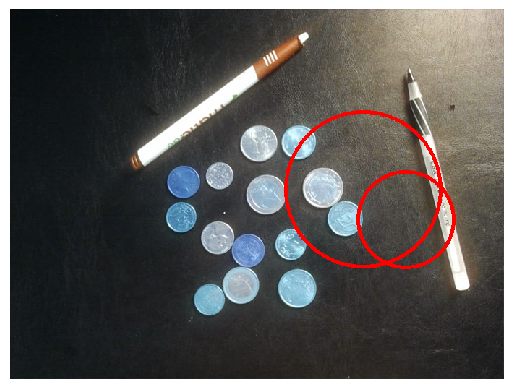

In [143]:
#need to access those channels 
for i, circle in enumerate(bestCircles):
    print(f"Circle {i + 1}: Center ({circle[0]}, {circle[1]}), Radius {circle[2]}")

result_image = drawCircles(img, circleFound, 100)
plt.imshow(result_image)
plt.title('')
plt.axis('off')
plt.show()
